# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

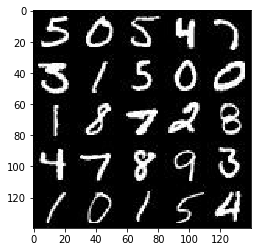

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

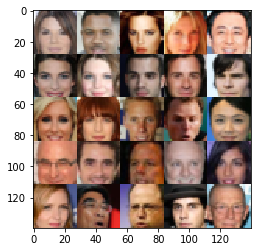

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [5]:
# Some fallbacks for old versions of tensorflow (1.3 on AWS)
try:
    leaky_relu = tf.nn.leaky_relu
except AttributeError:
    warnings.warn('Using fallback leaky_relu')
    def leaky_relu(inputs, alpha=0.2):
        return tf.maximum(inputs, inputs * alpha)
    

try:
    flatten = tf.layers.flatten
except AttributeError:
    warnings.warn('Using fallback flatten')
    import functools
    import operator
    
    def flatten(inputs):
        shape = inputs.get_shape()
        target_dim = functools.reduce(operator.mul, map(int, shape[1:]))
        return tf.reshape(inputs, [-1, target_dim])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Using fallback leaky_relu
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Using fallback flatten
  del sys.path[0]


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    random_inputs = tf.placeholder(tf.float32, shape=[None, z_dim], name='random_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs, random_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
KERNEL_SIZE = 5
STRIDES = 2


def conv2d(
    inputs, filters, is_training,
    normalization=True, activation=True, kernel_size=KERNEL_SIZE
):
    output = tf.layers.conv2d(
        inputs=inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def dense(inputs, units, is_training, normalization=True, activation=True):
    output = tf.layers.dense(
        inputs=inputs, units=units, use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    is_training = True
    with tf.variable_scope('discriminator', reuse=reuse):
        output = images
        # Shape 28x28xchannels
        output = conv2d(output, 128, is_training, normalization=False)
        # Shape is 14x14
        output = conv2d(output, 256, is_training)
        # Shape 7x7
        output = conv2d(output, 512, is_training)
        # Shape 4x4
        output = flatten(output)
        # Shape 4*4*512 = 8K
        
        output = dense(output, 512, is_training)
        
        logits = dense(output, 1, is_training, normalization=False, activation=False)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def conv2d_transpose(
    inputs, filters, is_training,
    normalization=True, activation=True, kernel_size=KERNEL_SIZE
):
    output = tf.layers.conv2d_transpose(
        inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output


def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        output = dense(z, 4 * 4 * 512, is_train)
        output = tf.reshape(output, [-1, 4, 4, 512])
        
        # Shape is 4x4
        output = conv2d_transpose(output, 256, is_train)
        # Shape is 8x8
        output = conv2d_transpose(output, 128, is_train)
        # Shape ix 16x16
        output = conv2d_transpose(
            output, out_channel_dim, is_train,
            normalization=False, activation=False
        )
        # Shape is 32x32xout_channel_dim
        output = tf.tanh(output)
        # Cut the the center of the generated image
        output = tf.image.crop_to_bounding_box(output, 2, 2, 28, 28)
        # Shape is 28x28xout_channel_dim
        
        # tanh generates number in range (-1, 1),
        # but we need to output in range (-.5, .5)
        # to match the pre-processing
        output *= 0.5
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_real, reuse=False
    )
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model, reuse=True
    )
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real, labels=tf.ones_like(discriminator_logits_real)
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_logits_fake)
    ))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_logits_fake)
    ))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_variables = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            d_loss, var_list=discriminator_variables
        )
        generator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            g_loss, var_list=generator_variables
        )
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
PRINT_EVERY = 5
VIEW_EVERY = PRINT_EVERY * 3

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    number_of_examples, *_, out_channel_dim = data_shape
    (
        real_images, z, learning_rate_tensor
    ) = model_inputs(*data_shape[1:], z_dim)
    batches_per_epoch = int(number_of_examples / batch_size)
    
    discriminator_loss, generator_loss = model_loss(
        real_images, z, out_channel_dim
    )
    discriminator_opt, generator_opt = model_opt(
        discriminator_loss, generator_loss, learning_rate_tensor, beta1
    )
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        show_output = functools.partial(
            show_generator_output, 
            sess, 16, z, out_channel_dim, data_image_mode
        )
        step = 0
        # Show the initial white noise
        show_output()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {
                    real_images: batch_images,
                    z: batch_z,
                    learning_rate_tensor: learning_rate,
                }
                sess.run(discriminator_opt, feed_dict=feed_dict)
                sess.run(generator_opt, feed_dict=feed_dict)
                if step % PRINT_EVERY == 0:
                    train_loss_discriminator = discriminator_loss.eval(feed_dict)
                    train_loss_generator = generator_loss.eval(feed_dict)
                    print(
                        'Epoch {epoch_i}/{epoch_count} '
                        'Step {step}/{steps}: '
                        'Discriminator Loss: {train_loss_discriminator:.4f}. '
                        'Generator Loss: {train_loss_generator:.4f}'.format(
                            epoch_i=epoch_i + 1,
                            epoch_count=epoch_count,
                            step=step + 1,
                            steps=batches_per_epoch * epoch_count,
                            train_loss_generator=train_loss_generator,
                            train_loss_discriminator=train_loss_discriminator
                        )
                    )
                step += 1
                if step % VIEW_EVERY == 0:
                    show_output()
                    
        # Show final result
        show_output()

##### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

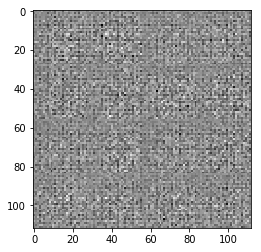

Epoch 1/2 Step 1/936: Discriminator Loss: 10.0631. Generator Loss: 6.1931
Epoch 1/2 Step 6/936: Discriminator Loss: 1.5965. Generator Loss: 0.8140
Epoch 1/2 Step 11/936: Discriminator Loss: 1.2403. Generator Loss: 0.7458


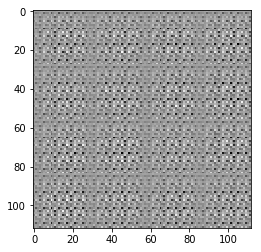

Epoch 1/2 Step 16/936: Discriminator Loss: 1.1525. Generator Loss: 0.7848
Epoch 1/2 Step 21/936: Discriminator Loss: 1.2018. Generator Loss: 0.8441
Epoch 1/2 Step 26/936: Discriminator Loss: 0.9969. Generator Loss: 0.9121


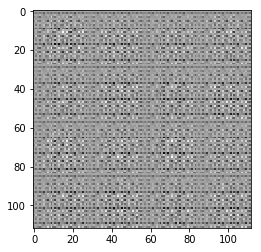

Epoch 1/2 Step 31/936: Discriminator Loss: 1.3647. Generator Loss: 0.9935
Epoch 1/2 Step 36/936: Discriminator Loss: 0.8973. Generator Loss: 1.0292
Epoch 1/2 Step 41/936: Discriminator Loss: 0.8171. Generator Loss: 1.0957


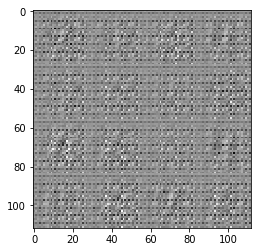

Epoch 1/2 Step 46/936: Discriminator Loss: 0.8932. Generator Loss: 1.1205
Epoch 1/2 Step 51/936: Discriminator Loss: 0.7157. Generator Loss: 1.2659
Epoch 1/2 Step 56/936: Discriminator Loss: 0.6764. Generator Loss: 1.2161


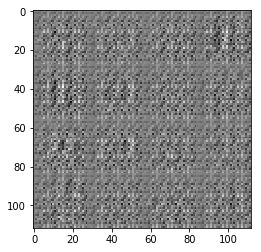

Epoch 1/2 Step 61/936: Discriminator Loss: 0.7154. Generator Loss: 1.3006
Epoch 1/2 Step 66/936: Discriminator Loss: 0.7682. Generator Loss: 1.2973
Epoch 1/2 Step 71/936: Discriminator Loss: 0.6387. Generator Loss: 1.2378


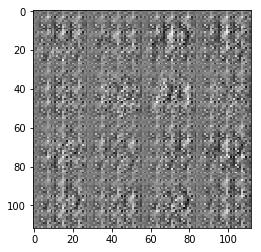

Epoch 1/2 Step 76/936: Discriminator Loss: 0.8083. Generator Loss: 1.4599
Epoch 1/2 Step 81/936: Discriminator Loss: 0.6329. Generator Loss: 1.1953
Epoch 1/2 Step 86/936: Discriminator Loss: 0.5599. Generator Loss: 1.4493


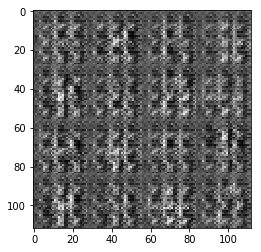

Epoch 1/2 Step 91/936: Discriminator Loss: 1.0044. Generator Loss: 1.7153
Epoch 1/2 Step 96/936: Discriminator Loss: 0.9326. Generator Loss: 0.8994
Epoch 1/2 Step 101/936: Discriminator Loss: 0.9983. Generator Loss: 1.0982


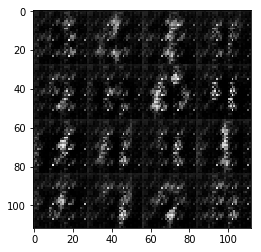

Epoch 1/2 Step 106/936: Discriminator Loss: 1.2348. Generator Loss: 0.7813
Epoch 1/2 Step 111/936: Discriminator Loss: 1.1977. Generator Loss: 1.2957
Epoch 1/2 Step 116/936: Discriminator Loss: 0.8497. Generator Loss: 1.1090


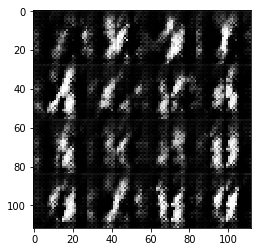

Epoch 1/2 Step 121/936: Discriminator Loss: 1.1933. Generator Loss: 1.2267
Epoch 1/2 Step 126/936: Discriminator Loss: 1.0618. Generator Loss: 0.8383
Epoch 1/2 Step 131/936: Discriminator Loss: 0.9507. Generator Loss: 0.8967


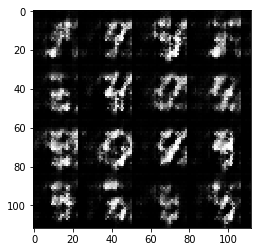

Epoch 1/2 Step 136/936: Discriminator Loss: 1.0058. Generator Loss: 0.9584
Epoch 1/2 Step 141/936: Discriminator Loss: 1.0768. Generator Loss: 0.8047
Epoch 1/2 Step 146/936: Discriminator Loss: 1.1977. Generator Loss: 0.6631


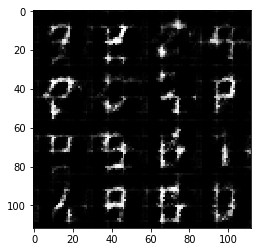

Epoch 1/2 Step 151/936: Discriminator Loss: 0.9263. Generator Loss: 1.1038
Epoch 1/2 Step 156/936: Discriminator Loss: 1.3940. Generator Loss: 0.7628
Epoch 1/2 Step 161/936: Discriminator Loss: 1.1922. Generator Loss: 0.8118


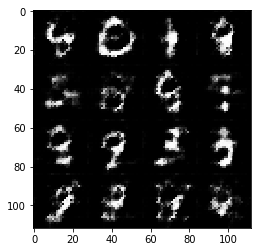

Epoch 1/2 Step 166/936: Discriminator Loss: 1.0649. Generator Loss: 0.7977
Epoch 1/2 Step 171/936: Discriminator Loss: 1.1422. Generator Loss: 0.7706
Epoch 1/2 Step 176/936: Discriminator Loss: 1.1255. Generator Loss: 0.8634


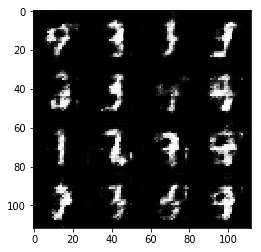

Epoch 1/2 Step 181/936: Discriminator Loss: 1.2194. Generator Loss: 0.8444
Epoch 1/2 Step 186/936: Discriminator Loss: 1.2281. Generator Loss: 0.7106
Epoch 1/2 Step 191/936: Discriminator Loss: 1.1725. Generator Loss: 0.6961


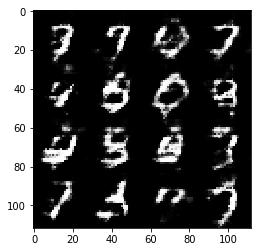

Epoch 1/2 Step 196/936: Discriminator Loss: 0.9568. Generator Loss: 0.8233
Epoch 1/2 Step 201/936: Discriminator Loss: 1.3052. Generator Loss: 0.8381
Epoch 1/2 Step 206/936: Discriminator Loss: 1.1743. Generator Loss: 0.9094


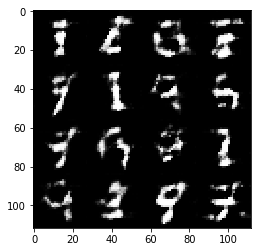

Epoch 1/2 Step 211/936: Discriminator Loss: 1.5078. Generator Loss: 0.6911
Epoch 1/2 Step 216/936: Discriminator Loss: 1.0344. Generator Loss: 0.8390
Epoch 1/2 Step 221/936: Discriminator Loss: 1.1090. Generator Loss: 0.9099


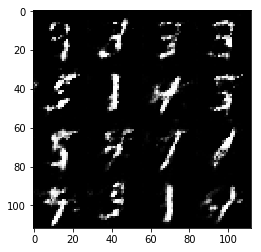

Epoch 1/2 Step 226/936: Discriminator Loss: 1.0668. Generator Loss: 0.7639
Epoch 1/2 Step 231/936: Discriminator Loss: 1.2412. Generator Loss: 1.0847
Epoch 1/2 Step 236/936: Discriminator Loss: 1.2304. Generator Loss: 0.7719


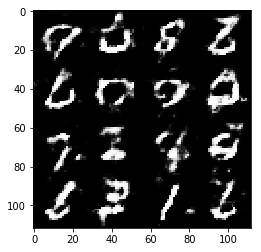

Epoch 1/2 Step 241/936: Discriminator Loss: 1.3297. Generator Loss: 0.9467
Epoch 1/2 Step 246/936: Discriminator Loss: 1.1318. Generator Loss: 0.7621
Epoch 1/2 Step 251/936: Discriminator Loss: 1.0482. Generator Loss: 0.8659


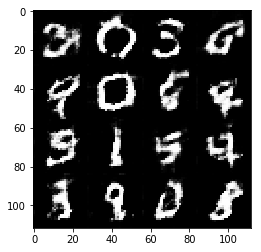

Epoch 1/2 Step 256/936: Discriminator Loss: 1.0588. Generator Loss: 0.8131
Epoch 1/2 Step 261/936: Discriminator Loss: 1.0740. Generator Loss: 0.9960
Epoch 1/2 Step 266/936: Discriminator Loss: 1.1134. Generator Loss: 0.8555


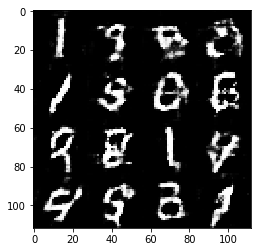

Epoch 1/2 Step 271/936: Discriminator Loss: 1.0163. Generator Loss: 0.8857
Epoch 1/2 Step 276/936: Discriminator Loss: 1.1128. Generator Loss: 0.8988
Epoch 1/2 Step 281/936: Discriminator Loss: 1.0337. Generator Loss: 0.9737


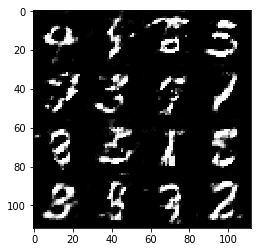

Epoch 1/2 Step 286/936: Discriminator Loss: 1.0949. Generator Loss: 0.8289
Epoch 1/2 Step 291/936: Discriminator Loss: 0.9660. Generator Loss: 0.9281
Epoch 1/2 Step 296/936: Discriminator Loss: 1.0961. Generator Loss: 0.8967


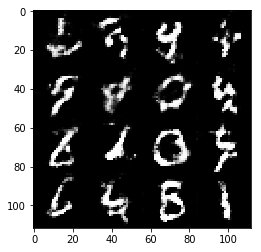

Epoch 1/2 Step 301/936: Discriminator Loss: 0.9459. Generator Loss: 1.0285
Epoch 1/2 Step 306/936: Discriminator Loss: 0.9310. Generator Loss: 0.8920
Epoch 1/2 Step 311/936: Discriminator Loss: 0.8942. Generator Loss: 0.9408


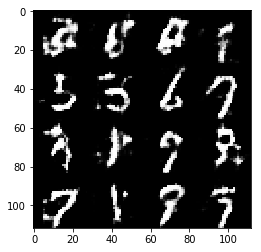

Epoch 1/2 Step 316/936: Discriminator Loss: 1.2495. Generator Loss: 1.0864
Epoch 1/2 Step 321/936: Discriminator Loss: 1.1510. Generator Loss: 0.8873
Epoch 1/2 Step 326/936: Discriminator Loss: 0.9067. Generator Loss: 1.0027


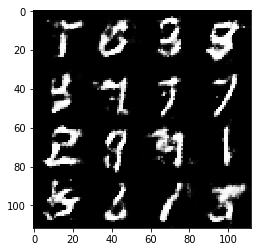

Epoch 1/2 Step 331/936: Discriminator Loss: 0.9518. Generator Loss: 0.9076
Epoch 1/2 Step 336/936: Discriminator Loss: 1.2933. Generator Loss: 0.6775
Epoch 1/2 Step 341/936: Discriminator Loss: 0.9410. Generator Loss: 0.9162


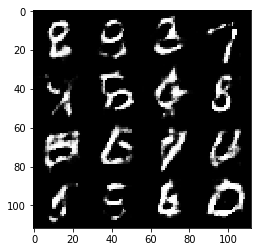

Epoch 1/2 Step 346/936: Discriminator Loss: 1.2027. Generator Loss: 0.9138
Epoch 1/2 Step 351/936: Discriminator Loss: 1.2341. Generator Loss: 0.8619
Epoch 1/2 Step 356/936: Discriminator Loss: 1.0522. Generator Loss: 0.8165


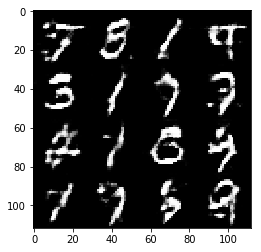

Epoch 1/2 Step 361/936: Discriminator Loss: 1.0268. Generator Loss: 0.9411
Epoch 1/2 Step 366/936: Discriminator Loss: 1.2435. Generator Loss: 0.9780
Epoch 1/2 Step 371/936: Discriminator Loss: 1.0112. Generator Loss: 0.8973


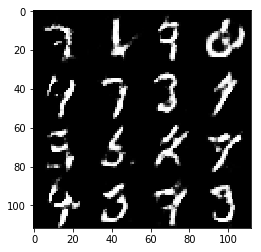

Epoch 1/2 Step 376/936: Discriminator Loss: 1.2196. Generator Loss: 0.9111
Epoch 1/2 Step 381/936: Discriminator Loss: 1.0969. Generator Loss: 0.7919
Epoch 1/2 Step 386/936: Discriminator Loss: 1.0135. Generator Loss: 0.8923


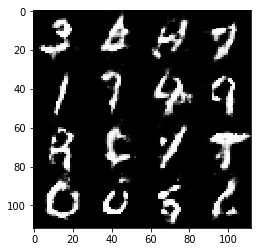

Epoch 1/2 Step 391/936: Discriminator Loss: 0.9912. Generator Loss: 0.9162
Epoch 1/2 Step 396/936: Discriminator Loss: 1.0090. Generator Loss: 0.7875
Epoch 1/2 Step 401/936: Discriminator Loss: 1.2835. Generator Loss: 0.7492


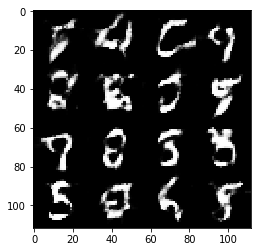

Epoch 1/2 Step 406/936: Discriminator Loss: 0.9757. Generator Loss: 0.7797
Epoch 1/2 Step 411/936: Discriminator Loss: 1.0002. Generator Loss: 0.8795
Epoch 1/2 Step 416/936: Discriminator Loss: 0.8371. Generator Loss: 1.0095


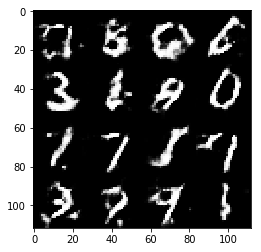

Epoch 1/2 Step 421/936: Discriminator Loss: 1.0334. Generator Loss: 1.4161
Epoch 1/2 Step 426/936: Discriminator Loss: 1.0174. Generator Loss: 0.9506
Epoch 1/2 Step 431/936: Discriminator Loss: 0.9360. Generator Loss: 1.0828


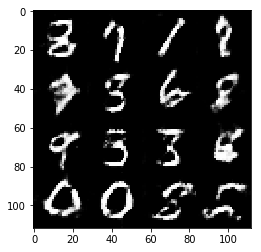

Epoch 1/2 Step 436/936: Discriminator Loss: 1.0161. Generator Loss: 1.0190
Epoch 1/2 Step 441/936: Discriminator Loss: 1.1644. Generator Loss: 0.6692
Epoch 1/2 Step 446/936: Discriminator Loss: 1.3296. Generator Loss: 0.8047


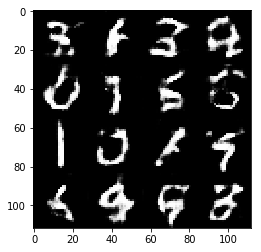

Epoch 1/2 Step 451/936: Discriminator Loss: 1.1947. Generator Loss: 0.9575
Epoch 1/2 Step 456/936: Discriminator Loss: 1.0926. Generator Loss: 0.8625
Epoch 1/2 Step 461/936: Discriminator Loss: 1.0020. Generator Loss: 0.8822


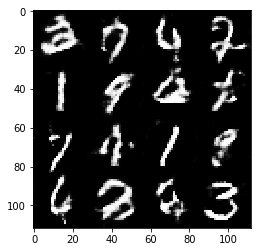

Epoch 1/2 Step 466/936: Discriminator Loss: 0.8208. Generator Loss: 1.0501
Epoch 2/2 Step 471/936: Discriminator Loss: 0.8919. Generator Loss: 0.9446
Epoch 2/2 Step 476/936: Discriminator Loss: 1.1333. Generator Loss: 0.9041


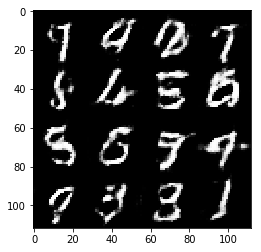

Epoch 2/2 Step 481/936: Discriminator Loss: 0.9363. Generator Loss: 0.9300
Epoch 2/2 Step 486/936: Discriminator Loss: 0.8903. Generator Loss: 1.0828
Epoch 2/2 Step 491/936: Discriminator Loss: 0.8644. Generator Loss: 1.0248


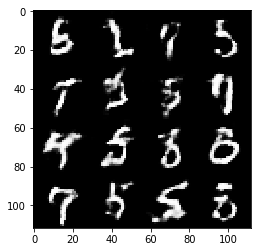

Epoch 2/2 Step 496/936: Discriminator Loss: 0.8562. Generator Loss: 1.0208
Epoch 2/2 Step 501/936: Discriminator Loss: 1.1196. Generator Loss: 0.7355
Epoch 2/2 Step 506/936: Discriminator Loss: 1.2075. Generator Loss: 1.0371


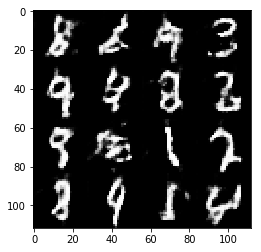

Epoch 2/2 Step 511/936: Discriminator Loss: 1.2112. Generator Loss: 1.0836
Epoch 2/2 Step 516/936: Discriminator Loss: 1.1999. Generator Loss: 0.9620
Epoch 2/2 Step 521/936: Discriminator Loss: 0.9506. Generator Loss: 0.9297


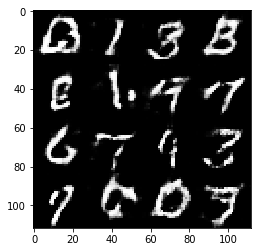

Epoch 2/2 Step 526/936: Discriminator Loss: 1.3018. Generator Loss: 0.7748
Epoch 2/2 Step 531/936: Discriminator Loss: 0.9082. Generator Loss: 0.9155
Epoch 2/2 Step 536/936: Discriminator Loss: 1.0371. Generator Loss: 0.8532


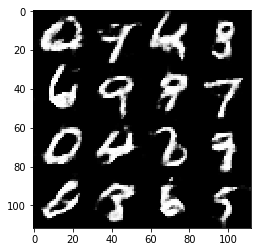

Epoch 2/2 Step 541/936: Discriminator Loss: 0.8852. Generator Loss: 1.0136
Epoch 2/2 Step 546/936: Discriminator Loss: 1.3137. Generator Loss: 0.9856
Epoch 2/2 Step 551/936: Discriminator Loss: 0.9211. Generator Loss: 1.0605


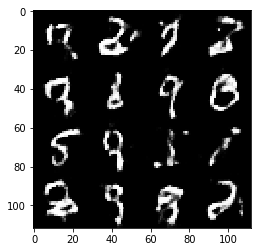

Epoch 2/2 Step 556/936: Discriminator Loss: 1.1626. Generator Loss: 0.8730
Epoch 2/2 Step 561/936: Discriminator Loss: 1.0968. Generator Loss: 0.8412
Epoch 2/2 Step 566/936: Discriminator Loss: 0.9273. Generator Loss: 0.9557


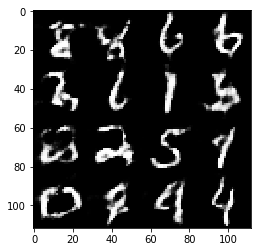

Epoch 2/2 Step 571/936: Discriminator Loss: 1.3027. Generator Loss: 1.3199
Epoch 2/2 Step 576/936: Discriminator Loss: 0.9491. Generator Loss: 0.8882
Epoch 2/2 Step 581/936: Discriminator Loss: 0.7984. Generator Loss: 1.1738


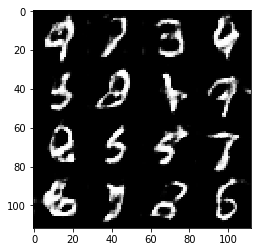

Epoch 2/2 Step 586/936: Discriminator Loss: 0.9698. Generator Loss: 1.1774
Epoch 2/2 Step 591/936: Discriminator Loss: 0.7903. Generator Loss: 1.0927
Epoch 2/2 Step 596/936: Discriminator Loss: 0.7965. Generator Loss: 1.0179


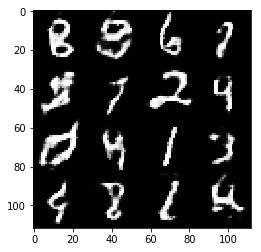

Epoch 2/2 Step 601/936: Discriminator Loss: 0.7326. Generator Loss: 1.2318
Epoch 2/2 Step 606/936: Discriminator Loss: 0.7778. Generator Loss: 0.9701
Epoch 2/2 Step 611/936: Discriminator Loss: 1.0621. Generator Loss: 1.3005


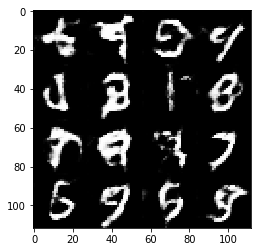

Epoch 2/2 Step 616/936: Discriminator Loss: 1.0394. Generator Loss: 0.8345
Epoch 2/2 Step 621/936: Discriminator Loss: 1.2855. Generator Loss: 1.2586
Epoch 2/2 Step 626/936: Discriminator Loss: 0.9509. Generator Loss: 1.0028


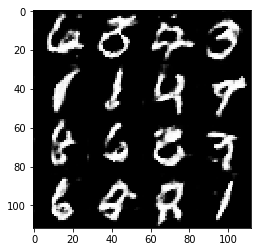

Epoch 2/2 Step 631/936: Discriminator Loss: 0.9281. Generator Loss: 1.3463
Epoch 2/2 Step 636/936: Discriminator Loss: 0.9637. Generator Loss: 0.7908
Epoch 2/2 Step 641/936: Discriminator Loss: 0.7092. Generator Loss: 1.2438


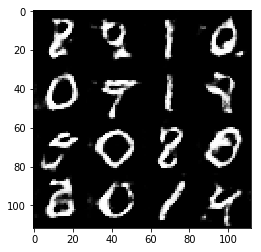

Epoch 2/2 Step 646/936: Discriminator Loss: 0.9522. Generator Loss: 0.7277
Epoch 2/2 Step 651/936: Discriminator Loss: 1.2267. Generator Loss: 1.1042
Epoch 2/2 Step 656/936: Discriminator Loss: 1.0822. Generator Loss: 0.7683


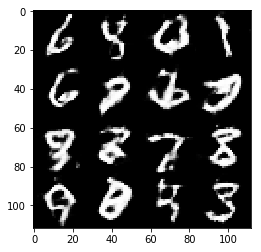

Epoch 2/2 Step 661/936: Discriminator Loss: 0.9242. Generator Loss: 1.1712
Epoch 2/2 Step 666/936: Discriminator Loss: 0.8314. Generator Loss: 0.9028
Epoch 2/2 Step 671/936: Discriminator Loss: 0.9079. Generator Loss: 0.8941


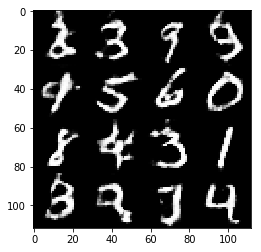

Epoch 2/2 Step 676/936: Discriminator Loss: 1.9744. Generator Loss: 1.6720
Epoch 2/2 Step 681/936: Discriminator Loss: 0.8839. Generator Loss: 1.0654
Epoch 2/2 Step 686/936: Discriminator Loss: 1.0245. Generator Loss: 0.8006


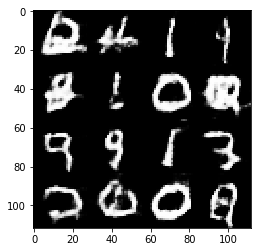

Epoch 2/2 Step 691/936: Discriminator Loss: 1.1711. Generator Loss: 1.0163
Epoch 2/2 Step 696/936: Discriminator Loss: 0.9940. Generator Loss: 0.7424
Epoch 2/2 Step 701/936: Discriminator Loss: 0.8660. Generator Loss: 1.0798


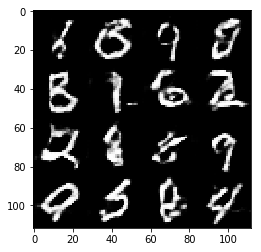

Epoch 2/2 Step 706/936: Discriminator Loss: 1.1361. Generator Loss: 1.0983
Epoch 2/2 Step 711/936: Discriminator Loss: 0.8406. Generator Loss: 1.2086
Epoch 2/2 Step 716/936: Discriminator Loss: 0.6972. Generator Loss: 1.1329


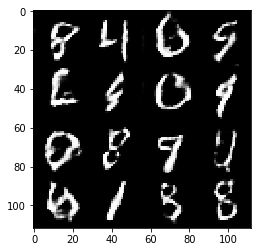

Epoch 2/2 Step 721/936: Discriminator Loss: 0.9911. Generator Loss: 0.8796
Epoch 2/2 Step 726/936: Discriminator Loss: 0.9401. Generator Loss: 0.9352
Epoch 2/2 Step 731/936: Discriminator Loss: 0.7314. Generator Loss: 1.9043


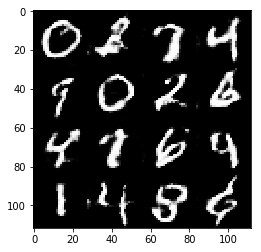

Epoch 2/2 Step 736/936: Discriminator Loss: 0.8048. Generator Loss: 1.3703
Epoch 2/2 Step 741/936: Discriminator Loss: 0.6232. Generator Loss: 1.3398
Epoch 2/2 Step 746/936: Discriminator Loss: 1.4414. Generator Loss: 2.2311


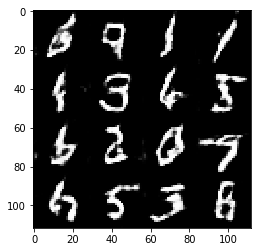

Epoch 2/2 Step 751/936: Discriminator Loss: 1.4861. Generator Loss: 1.2074
Epoch 2/2 Step 756/936: Discriminator Loss: 0.8419. Generator Loss: 0.9657
Epoch 2/2 Step 761/936: Discriminator Loss: 0.9178. Generator Loss: 0.9137


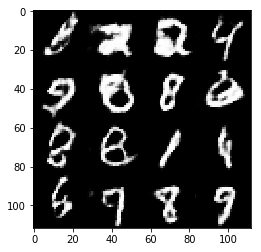

Epoch 2/2 Step 766/936: Discriminator Loss: 1.0162. Generator Loss: 1.1140
Epoch 2/2 Step 771/936: Discriminator Loss: 0.9883. Generator Loss: 0.9720
Epoch 2/2 Step 776/936: Discriminator Loss: 0.8519. Generator Loss: 0.9392


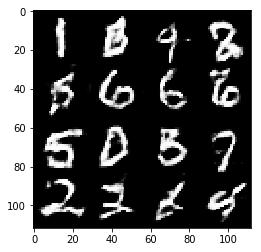

Epoch 2/2 Step 781/936: Discriminator Loss: 0.8391. Generator Loss: 1.2537
Epoch 2/2 Step 786/936: Discriminator Loss: 1.1645. Generator Loss: 0.6210
Epoch 2/2 Step 791/936: Discriminator Loss: 0.9003. Generator Loss: 1.0480


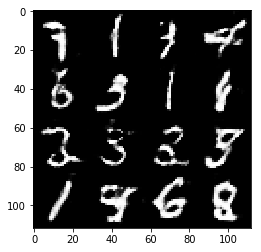

Epoch 2/2 Step 796/936: Discriminator Loss: 0.8761. Generator Loss: 0.7894
Epoch 2/2 Step 801/936: Discriminator Loss: 0.9090. Generator Loss: 0.8506
Epoch 2/2 Step 806/936: Discriminator Loss: 0.9148. Generator Loss: 0.8745


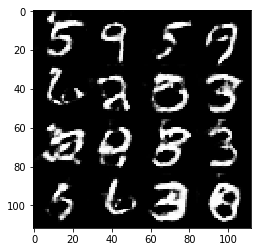

Epoch 2/2 Step 811/936: Discriminator Loss: 0.7431. Generator Loss: 1.2917
Epoch 2/2 Step 816/936: Discriminator Loss: 1.1897. Generator Loss: 0.7273
Epoch 2/2 Step 821/936: Discriminator Loss: 0.8959. Generator Loss: 1.0937


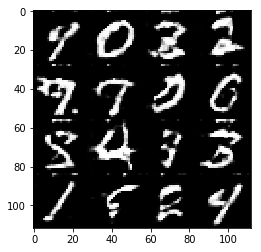

Epoch 2/2 Step 826/936: Discriminator Loss: 0.5868. Generator Loss: 1.2884
Epoch 2/2 Step 831/936: Discriminator Loss: 0.7059. Generator Loss: 1.5908
Epoch 2/2 Step 836/936: Discriminator Loss: 0.5997. Generator Loss: 1.8528


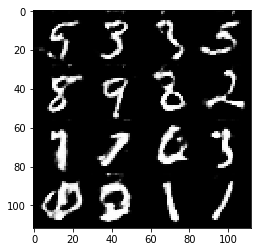

Epoch 2/2 Step 841/936: Discriminator Loss: 0.8529. Generator Loss: 0.9044
Epoch 2/2 Step 846/936: Discriminator Loss: 0.9057. Generator Loss: 1.0788
Epoch 2/2 Step 851/936: Discriminator Loss: 1.5100. Generator Loss: 0.8909


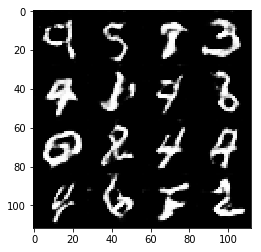

Epoch 2/2 Step 856/936: Discriminator Loss: 0.9281. Generator Loss: 0.8181
Epoch 2/2 Step 861/936: Discriminator Loss: 1.1139. Generator Loss: 0.8703
Epoch 2/2 Step 866/936: Discriminator Loss: 0.8301. Generator Loss: 1.3876


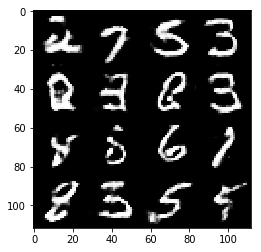

Epoch 2/2 Step 871/936: Discriminator Loss: 0.8316. Generator Loss: 0.9471
Epoch 2/2 Step 876/936: Discriminator Loss: 1.3458. Generator Loss: 0.5646
Epoch 2/2 Step 881/936: Discriminator Loss: 0.6382. Generator Loss: 1.6248


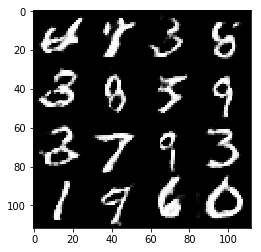

Epoch 2/2 Step 886/936: Discriminator Loss: 0.6118. Generator Loss: 1.4310
Epoch 2/2 Step 891/936: Discriminator Loss: 0.9057. Generator Loss: 0.7083
Epoch 2/2 Step 896/936: Discriminator Loss: 0.8109. Generator Loss: 1.4448


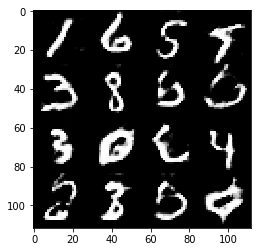

Epoch 2/2 Step 901/936: Discriminator Loss: 1.0200. Generator Loss: 0.8532
Epoch 2/2 Step 906/936: Discriminator Loss: 0.7949. Generator Loss: 0.9747
Epoch 2/2 Step 911/936: Discriminator Loss: 1.3105. Generator Loss: 0.5489


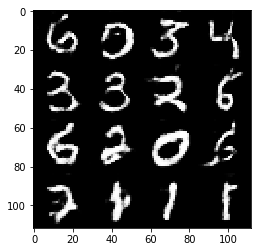

Epoch 2/2 Step 916/936: Discriminator Loss: 0.7110. Generator Loss: 1.0677
Epoch 2/2 Step 921/936: Discriminator Loss: 0.7259. Generator Loss: 1.3614
Epoch 2/2 Step 926/936: Discriminator Loss: 0.6213. Generator Loss: 1.5890


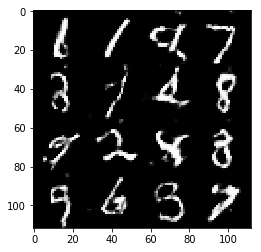

Epoch 2/2 Step 931/936: Discriminator Loss: 0.5742. Generator Loss: 1.5679
Epoch 2/2 Step 936/936: Discriminator Loss: 0.4342. Generator Loss: 1.5373


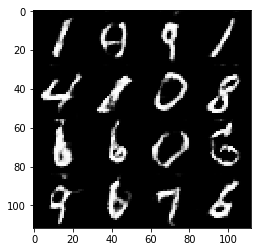

In [41]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

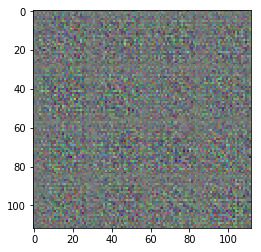

Epoch 1/1 Step 1/791: Discriminator Loss: 5.7686. Generator Loss: 1.6657
Epoch 1/1 Step 6/791: Discriminator Loss: 1.9509. Generator Loss: 0.9793
Epoch 1/1 Step 11/791: Discriminator Loss: 1.6342. Generator Loss: 0.9539


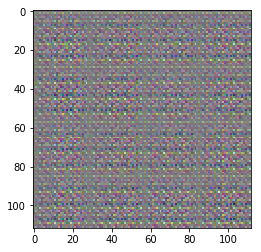

Epoch 1/1 Step 16/791: Discriminator Loss: 1.5433. Generator Loss: 0.9614
Epoch 1/1 Step 21/791: Discriminator Loss: 1.4478. Generator Loss: 0.9054
Epoch 1/1 Step 26/791: Discriminator Loss: 1.2161. Generator Loss: 0.8426


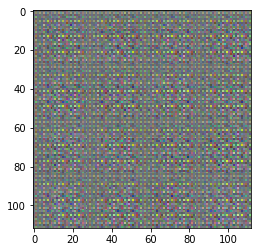

Epoch 1/1 Step 31/791: Discriminator Loss: 1.1055. Generator Loss: 0.8146
Epoch 1/1 Step 36/791: Discriminator Loss: 1.0238. Generator Loss: 0.8511
Epoch 1/1 Step 41/791: Discriminator Loss: 1.1315. Generator Loss: 0.9404


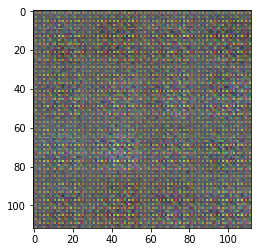

Epoch 1/1 Step 46/791: Discriminator Loss: 1.1623. Generator Loss: 0.9174
Epoch 1/1 Step 51/791: Discriminator Loss: 1.0407. Generator Loss: 0.8706
Epoch 1/1 Step 56/791: Discriminator Loss: 1.1004. Generator Loss: 0.9077


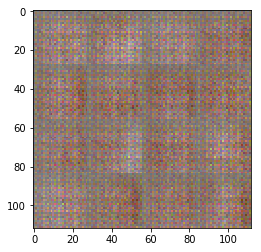

Epoch 1/1 Step 61/791: Discriminator Loss: 1.0733. Generator Loss: 0.9540
Epoch 1/1 Step 66/791: Discriminator Loss: 1.1522. Generator Loss: 0.8839
Epoch 1/1 Step 71/791: Discriminator Loss: 1.0477. Generator Loss: 0.8878


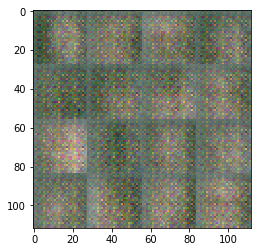

Epoch 1/1 Step 76/791: Discriminator Loss: 1.2912. Generator Loss: 1.0410
Epoch 1/1 Step 81/791: Discriminator Loss: 1.0708. Generator Loss: 1.0431
Epoch 1/1 Step 86/791: Discriminator Loss: 1.0716. Generator Loss: 1.1130


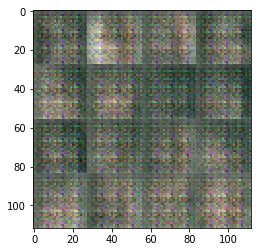

Epoch 1/1 Step 91/791: Discriminator Loss: 1.0435. Generator Loss: 1.0071
Epoch 1/1 Step 96/791: Discriminator Loss: 0.9607. Generator Loss: 1.2550
Epoch 1/1 Step 101/791: Discriminator Loss: 0.9688. Generator Loss: 0.9234


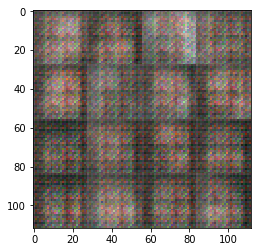

Epoch 1/1 Step 106/791: Discriminator Loss: 0.9116. Generator Loss: 0.9352
Epoch 1/1 Step 111/791: Discriminator Loss: 0.9016. Generator Loss: 0.9251
Epoch 1/1 Step 116/791: Discriminator Loss: 0.6531. Generator Loss: 1.1117


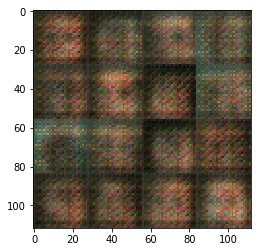

Epoch 1/1 Step 121/791: Discriminator Loss: 0.9528. Generator Loss: 0.9227
Epoch 1/1 Step 126/791: Discriminator Loss: 0.9645. Generator Loss: 0.9398
Epoch 1/1 Step 131/791: Discriminator Loss: 0.9588. Generator Loss: 1.0494


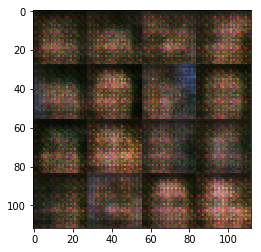

Epoch 1/1 Step 136/791: Discriminator Loss: 0.8381. Generator Loss: 1.1518
Epoch 1/1 Step 141/791: Discriminator Loss: 0.8443. Generator Loss: 1.3502
Epoch 1/1 Step 146/791: Discriminator Loss: 1.3919. Generator Loss: 0.5433


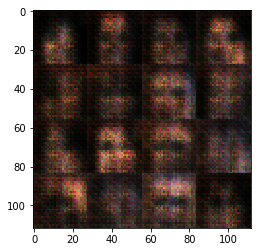

Epoch 1/1 Step 151/791: Discriminator Loss: 0.8328. Generator Loss: 1.0834
Epoch 1/1 Step 156/791: Discriminator Loss: 0.8978. Generator Loss: 0.8202
Epoch 1/1 Step 161/791: Discriminator Loss: 1.3025. Generator Loss: 1.1821


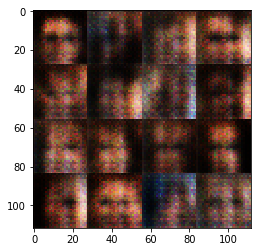

Epoch 1/1 Step 166/791: Discriminator Loss: 0.7733. Generator Loss: 1.0294
Epoch 1/1 Step 171/791: Discriminator Loss: 0.8687. Generator Loss: 0.9702
Epoch 1/1 Step 176/791: Discriminator Loss: 0.9027. Generator Loss: 1.1138


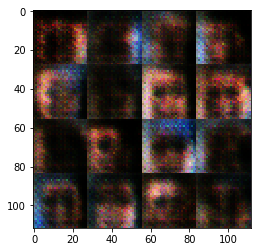

Epoch 1/1 Step 181/791: Discriminator Loss: 0.7085. Generator Loss: 1.0573
Epoch 1/1 Step 186/791: Discriminator Loss: 0.8586. Generator Loss: 1.0219
Epoch 1/1 Step 191/791: Discriminator Loss: 0.8996. Generator Loss: 0.9888


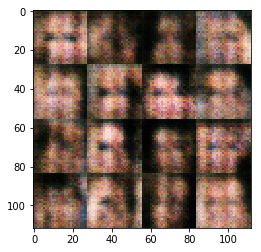

Epoch 1/1 Step 196/791: Discriminator Loss: 0.9365. Generator Loss: 1.1016
Epoch 1/1 Step 201/791: Discriminator Loss: 0.9233. Generator Loss: 1.0818
Epoch 1/1 Step 206/791: Discriminator Loss: 0.8790. Generator Loss: 0.7970


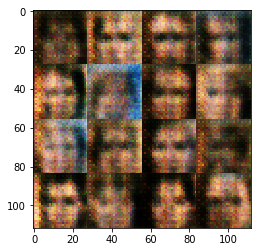

Epoch 1/1 Step 211/791: Discriminator Loss: 1.1788. Generator Loss: 0.8300
Epoch 1/1 Step 216/791: Discriminator Loss: 1.1533. Generator Loss: 0.6233
Epoch 1/1 Step 221/791: Discriminator Loss: 0.6622. Generator Loss: 1.3396


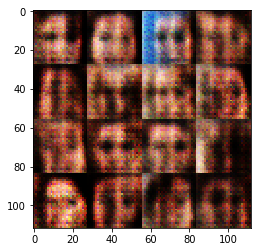

Epoch 1/1 Step 226/791: Discriminator Loss: 0.9302. Generator Loss: 0.9698
Epoch 1/1 Step 231/791: Discriminator Loss: 1.0800. Generator Loss: 0.9338
Epoch 1/1 Step 236/791: Discriminator Loss: 1.1900. Generator Loss: 0.6772


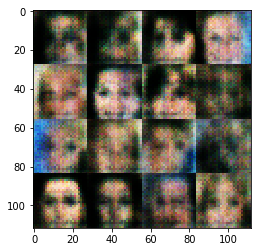

Epoch 1/1 Step 241/791: Discriminator Loss: 1.5487. Generator Loss: 1.0811
Epoch 1/1 Step 246/791: Discriminator Loss: 1.1610. Generator Loss: 0.8149
Epoch 1/1 Step 251/791: Discriminator Loss: 0.9741. Generator Loss: 1.2331


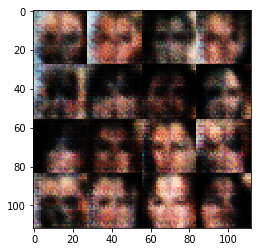

Epoch 1/1 Step 256/791: Discriminator Loss: 1.1077. Generator Loss: 0.7682
Epoch 1/1 Step 261/791: Discriminator Loss: 1.3030. Generator Loss: 0.5595
Epoch 1/1 Step 266/791: Discriminator Loss: 1.2411. Generator Loss: 0.5825


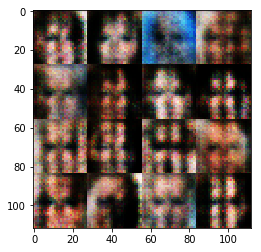

Epoch 1/1 Step 271/791: Discriminator Loss: 1.0557. Generator Loss: 0.8853
Epoch 1/1 Step 276/791: Discriminator Loss: 0.9642. Generator Loss: 0.9192
Epoch 1/1 Step 281/791: Discriminator Loss: 1.0743. Generator Loss: 0.8361


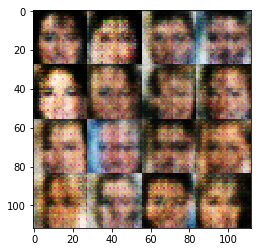

Epoch 1/1 Step 286/791: Discriminator Loss: 1.1706. Generator Loss: 1.0689
Epoch 1/1 Step 291/791: Discriminator Loss: 1.0473. Generator Loss: 0.9526
Epoch 1/1 Step 296/791: Discriminator Loss: 1.2079. Generator Loss: 0.8400


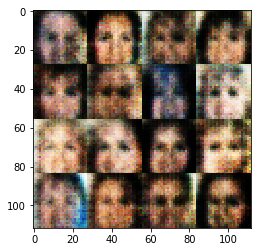

Epoch 1/1 Step 301/791: Discriminator Loss: 0.9691. Generator Loss: 0.8526
Epoch 1/1 Step 306/791: Discriminator Loss: 1.0748. Generator Loss: 0.9089
Epoch 1/1 Step 311/791: Discriminator Loss: 1.1816. Generator Loss: 0.8835


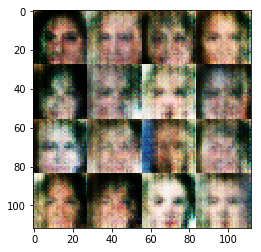

Epoch 1/1 Step 316/791: Discriminator Loss: 0.8446. Generator Loss: 0.9764
Epoch 1/1 Step 321/791: Discriminator Loss: 1.0503. Generator Loss: 0.6918
Epoch 1/1 Step 326/791: Discriminator Loss: 0.8128. Generator Loss: 0.9983


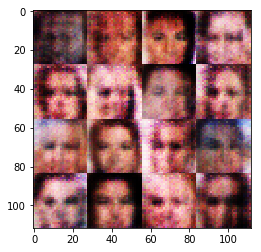

Epoch 1/1 Step 331/791: Discriminator Loss: 1.3489. Generator Loss: 0.8309
Epoch 1/1 Step 336/791: Discriminator Loss: 0.9529. Generator Loss: 0.8752
Epoch 1/1 Step 341/791: Discriminator Loss: 0.8916. Generator Loss: 0.9924


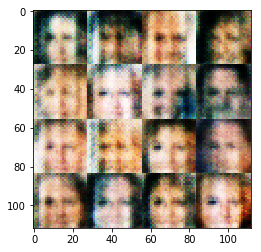

Epoch 1/1 Step 346/791: Discriminator Loss: 0.9808. Generator Loss: 0.7760
Epoch 1/1 Step 351/791: Discriminator Loss: 1.0408. Generator Loss: 0.9078
Epoch 1/1 Step 356/791: Discriminator Loss: 1.0593. Generator Loss: 0.9186


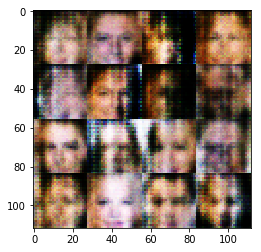

Epoch 1/1 Step 361/791: Discriminator Loss: 0.8381. Generator Loss: 1.1678
Epoch 1/1 Step 366/791: Discriminator Loss: 0.8485. Generator Loss: 1.1392
Epoch 1/1 Step 371/791: Discriminator Loss: 1.0200. Generator Loss: 1.0295


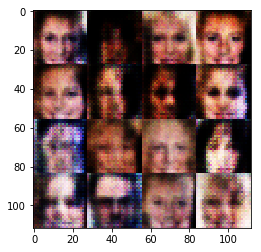

Epoch 1/1 Step 376/791: Discriminator Loss: 0.9487. Generator Loss: 1.1225
Epoch 1/1 Step 381/791: Discriminator Loss: 0.9573. Generator Loss: 0.9282
Epoch 1/1 Step 386/791: Discriminator Loss: 0.7251. Generator Loss: 1.1094


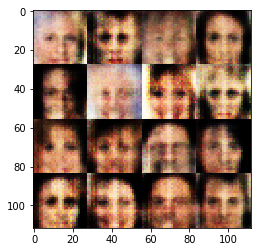

Epoch 1/1 Step 391/791: Discriminator Loss: 1.4802. Generator Loss: 0.8551
Epoch 1/1 Step 396/791: Discriminator Loss: 1.2888. Generator Loss: 0.6950
Epoch 1/1 Step 401/791: Discriminator Loss: 0.9562. Generator Loss: 1.0451


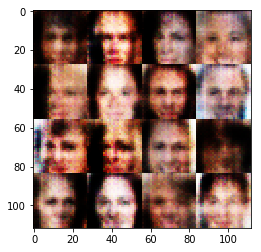

Epoch 1/1 Step 406/791: Discriminator Loss: 0.8526. Generator Loss: 0.9739
Epoch 1/1 Step 411/791: Discriminator Loss: 0.9793. Generator Loss: 0.8659
Epoch 1/1 Step 416/791: Discriminator Loss: 1.0145. Generator Loss: 0.7852


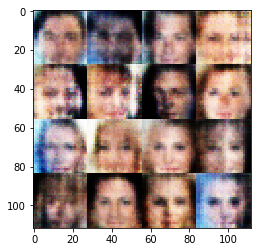

Epoch 1/1 Step 421/791: Discriminator Loss: 1.2644. Generator Loss: 0.9467
Epoch 1/1 Step 426/791: Discriminator Loss: 1.4400. Generator Loss: 0.8217
Epoch 1/1 Step 431/791: Discriminator Loss: 0.9694. Generator Loss: 0.8810


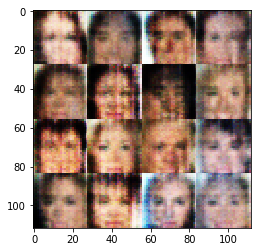

Epoch 1/1 Step 436/791: Discriminator Loss: 1.0301. Generator Loss: 0.9053
Epoch 1/1 Step 441/791: Discriminator Loss: 1.1054. Generator Loss: 0.8087
Epoch 1/1 Step 446/791: Discriminator Loss: 1.0071. Generator Loss: 0.9169


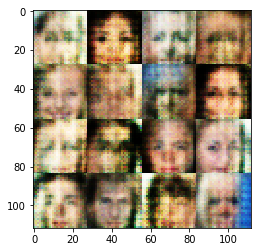

Epoch 1/1 Step 451/791: Discriminator Loss: 0.9777. Generator Loss: 0.8528
Epoch 1/1 Step 456/791: Discriminator Loss: 1.0959. Generator Loss: 0.8886
Epoch 1/1 Step 461/791: Discriminator Loss: 0.9312. Generator Loss: 0.8574


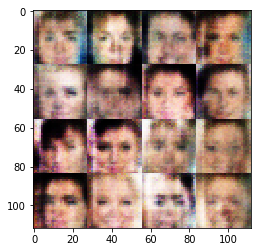

Epoch 1/1 Step 466/791: Discriminator Loss: 1.1850. Generator Loss: 0.8636
Epoch 1/1 Step 471/791: Discriminator Loss: 1.4663. Generator Loss: 0.4921
Epoch 1/1 Step 476/791: Discriminator Loss: 1.0905. Generator Loss: 0.8363


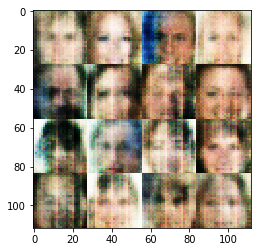

Epoch 1/1 Step 481/791: Discriminator Loss: 0.9229. Generator Loss: 1.0766
Epoch 1/1 Step 486/791: Discriminator Loss: 1.0526. Generator Loss: 0.9336
Epoch 1/1 Step 491/791: Discriminator Loss: 1.1924. Generator Loss: 1.0802


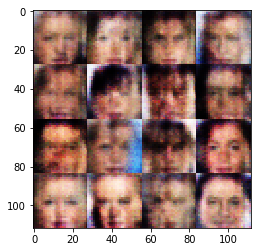

Epoch 1/1 Step 496/791: Discriminator Loss: 0.9594. Generator Loss: 0.9419
Epoch 1/1 Step 501/791: Discriminator Loss: 1.0707. Generator Loss: 0.9186
Epoch 1/1 Step 506/791: Discriminator Loss: 0.8992. Generator Loss: 0.9878


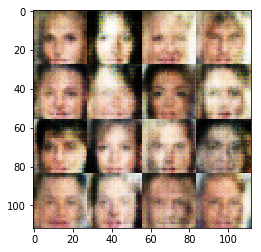

Epoch 1/1 Step 511/791: Discriminator Loss: 1.0085. Generator Loss: 1.0764
Epoch 1/1 Step 516/791: Discriminator Loss: 1.0807. Generator Loss: 0.7223
Epoch 1/1 Step 521/791: Discriminator Loss: 1.1086. Generator Loss: 0.7360


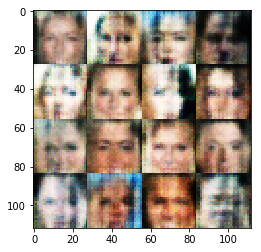

Epoch 1/1 Step 526/791: Discriminator Loss: 1.0840. Generator Loss: 0.9284
Epoch 1/1 Step 531/791: Discriminator Loss: 1.2602. Generator Loss: 0.9489
Epoch 1/1 Step 536/791: Discriminator Loss: 0.9011. Generator Loss: 0.9490


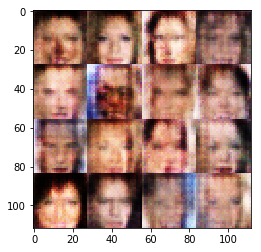

Epoch 1/1 Step 541/791: Discriminator Loss: 0.9641. Generator Loss: 1.0248
Epoch 1/1 Step 546/791: Discriminator Loss: 1.2354. Generator Loss: 0.6614
Epoch 1/1 Step 551/791: Discriminator Loss: 0.6593. Generator Loss: 1.1567


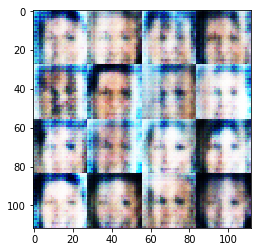

Epoch 1/1 Step 556/791: Discriminator Loss: 0.5462. Generator Loss: 1.2075
Epoch 1/1 Step 561/791: Discriminator Loss: 0.8492. Generator Loss: 1.2601
Epoch 1/1 Step 566/791: Discriminator Loss: 0.8107. Generator Loss: 1.2910


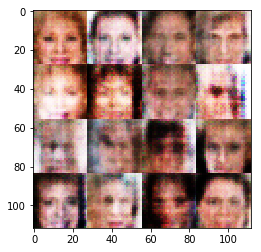

Epoch 1/1 Step 571/791: Discriminator Loss: 0.8415. Generator Loss: 0.8193
Epoch 1/1 Step 576/791: Discriminator Loss: 0.8484. Generator Loss: 1.0336
Epoch 1/1 Step 581/791: Discriminator Loss: 0.9847. Generator Loss: 1.0652


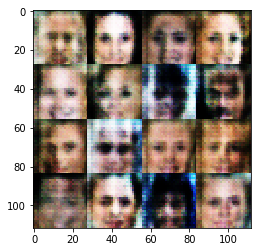

Epoch 1/1 Step 586/791: Discriminator Loss: 1.0065. Generator Loss: 1.0832
Epoch 1/1 Step 591/791: Discriminator Loss: 0.8838. Generator Loss: 1.0048
Epoch 1/1 Step 596/791: Discriminator Loss: 0.8546. Generator Loss: 1.0086


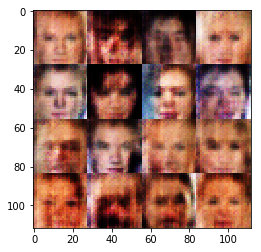

Epoch 1/1 Step 601/791: Discriminator Loss: 0.8251. Generator Loss: 1.1348
Epoch 1/1 Step 606/791: Discriminator Loss: 0.6802. Generator Loss: 1.3464
Epoch 1/1 Step 611/791: Discriminator Loss: 1.2943. Generator Loss: 0.6148


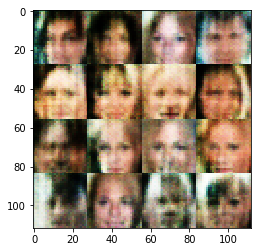

Epoch 1/1 Step 616/791: Discriminator Loss: 0.8257. Generator Loss: 1.1886
Epoch 1/1 Step 621/791: Discriminator Loss: 0.9436. Generator Loss: 1.1231
Epoch 1/1 Step 626/791: Discriminator Loss: 0.8259. Generator Loss: 0.9811


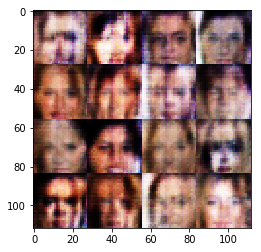

Epoch 1/1 Step 631/791: Discriminator Loss: 1.1687. Generator Loss: 0.8950
Epoch 1/1 Step 636/791: Discriminator Loss: 0.8980. Generator Loss: 1.0320
Epoch 1/1 Step 641/791: Discriminator Loss: 0.8658. Generator Loss: 0.9853


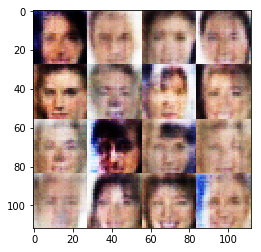

Epoch 1/1 Step 646/791: Discriminator Loss: 0.7903. Generator Loss: 0.9349
Epoch 1/1 Step 651/791: Discriminator Loss: 0.9381. Generator Loss: 1.0702
Epoch 1/1 Step 656/791: Discriminator Loss: 0.7946. Generator Loss: 1.1448


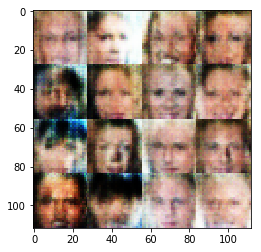

Epoch 1/1 Step 661/791: Discriminator Loss: 1.1410. Generator Loss: 0.6794
Epoch 1/1 Step 666/791: Discriminator Loss: 0.7776. Generator Loss: 1.1331
Epoch 1/1 Step 671/791: Discriminator Loss: 0.9110. Generator Loss: 1.0636


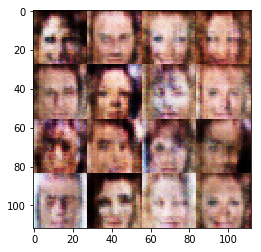

Epoch 1/1 Step 676/791: Discriminator Loss: 0.8384. Generator Loss: 0.9614
Epoch 1/1 Step 681/791: Discriminator Loss: 0.9622. Generator Loss: 0.7672
Epoch 1/1 Step 686/791: Discriminator Loss: 0.7554. Generator Loss: 1.0082


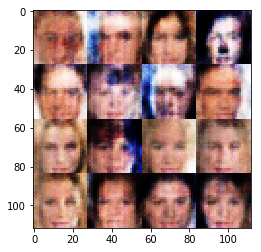

Epoch 1/1 Step 691/791: Discriminator Loss: 0.9326. Generator Loss: 0.9197
Epoch 1/1 Step 696/791: Discriminator Loss: 0.8982. Generator Loss: 1.0692
Epoch 1/1 Step 701/791: Discriminator Loss: 1.0199. Generator Loss: 0.9154


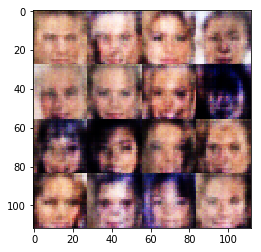

Epoch 1/1 Step 706/791: Discriminator Loss: 0.7355. Generator Loss: 1.2686
Epoch 1/1 Step 711/791: Discriminator Loss: 0.9539. Generator Loss: 0.8693
Epoch 1/1 Step 716/791: Discriminator Loss: 0.9989. Generator Loss: 0.8519


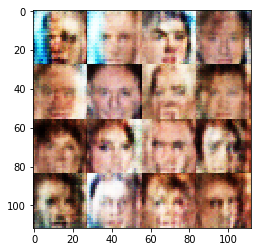

Epoch 1/1 Step 721/791: Discriminator Loss: 0.8006. Generator Loss: 0.9698
Epoch 1/1 Step 726/791: Discriminator Loss: 0.9583. Generator Loss: 1.2861
Epoch 1/1 Step 731/791: Discriminator Loss: 0.7608. Generator Loss: 1.3952


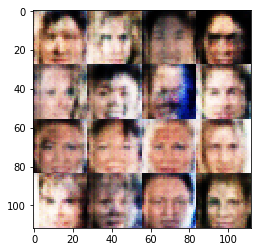

Epoch 1/1 Step 736/791: Discriminator Loss: 0.8908. Generator Loss: 1.6039
Epoch 1/1 Step 741/791: Discriminator Loss: 0.7055. Generator Loss: 1.2793
Epoch 1/1 Step 746/791: Discriminator Loss: 0.7488. Generator Loss: 1.0280


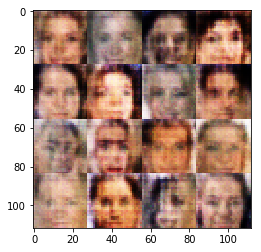

Epoch 1/1 Step 751/791: Discriminator Loss: 1.2065. Generator Loss: 0.9004
Epoch 1/1 Step 756/791: Discriminator Loss: 0.9087. Generator Loss: 1.1098
Epoch 1/1 Step 761/791: Discriminator Loss: 0.8103. Generator Loss: 1.2664


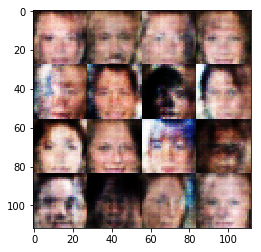

Epoch 1/1 Step 766/791: Discriminator Loss: 0.9029. Generator Loss: 1.1139
Epoch 1/1 Step 771/791: Discriminator Loss: 0.8280. Generator Loss: 1.2185
Epoch 1/1 Step 776/791: Discriminator Loss: 0.7171. Generator Loss: 1.0925


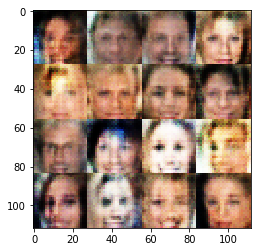

Epoch 1/1 Step 781/791: Discriminator Loss: 1.0717. Generator Loss: 1.4174
Epoch 1/1 Step 786/791: Discriminator Loss: 0.8403. Generator Loss: 0.8862
Epoch 1/1 Step 791/791: Discriminator Loss: 1.0267. Generator Loss: 0.8123


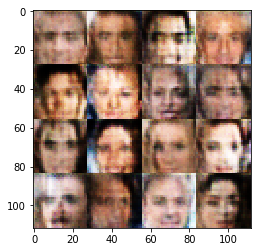

In [44]:
batch_size = 256
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.